Loading the package & Configure the Environment.

In [ ]:
! kill -9 -1

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
from tqdm import tqdm
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=1c42ea2cf91ca3701f548fa1e5122e4aee055b57f06a328b4a76e2db68043d32
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 112.5 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [2]:
import torch

torch.cuda.empty_cache()

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("There are {} GPUs available.".format(torch.cuda.device_count()))
    print("We will use GPU {}".format(torch.cuda.get_device_name(0)))
else:
    print("There is no GPU available, using the CPU instead!")
    device = torch.device("cpu")

There are 1 GPUs available.
We will use GPU Tesla T4


Now Loading the Data.

In [4]:
import pandas as pd

part_1 = pd.read_csv("dc_part_v3.csv")

In [5]:
part_1.shape

(124293, 147)

In [6]:
init_record = part_1 
init_record = init_record.set_index(['_key_client_id', '_key_occurreddate_month'])

In [7]:
init_record.head(10)

incident_catgry_care_concern_piv  ...  diagnosiscat_dementia_piv
_key_client_id                       _key_occurreddate_month                                    ...                           
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01T00:00:00.0                                   0  ...                          0
                                     2019-05-01T00:00:00.0                                   0  ...                          0
                                     2019-06-01T00:00:00.0                                   0  ...                          0
                                     2019-07-01T00:00:00.0                                   0  ...                          0
                                     2019-08-01T00:00:00.0                                   0  ...                          0
                                     2019-09-01T00:00:00.0                                   0  ...                          0
                                     2019-10-01T00:00:00.0                                   0  ...                          0
                                     2019-11-01T00:00:00.0                                   0  ...                          0
                                     2019-12-01T00:00:00.0                                   0  ...                          0
                                     2020-01-01T00:00:00.0                                   0  ...                          0

[10 rows x 145 columns]

In [8]:
print("The Length of Loading Data is {}".format(len(init_record)))

The Length of Loading Data is 124293


In [9]:
# summarize the total number of clients (year)
index_dict = {}
for ind in init_record.index:
    if ind[0] not in index_dict:
        index_dict[ind[0]] = []
        index_dict[ind[0]].append(ind[1])
    else:
        index_dict[ind[0]].append(ind[1])

print(len(index_dict))

14387


In [10]:
# Plot the distribution of record number
from collections import defaultdict
from tqdm import tqdm

record_num = defaultdict(list)
record_list = []

for id, value in tqdm(index_dict.items()):
    record_num[len(value)].append(id)
    record_list.append(len(value))

print('\nThe Length of the record number dictionary is {}'.format(len(record_num)))
print(len(record_list))

100%|██████████| 14387/14387 [00:00<00:00, 843917.15it/s]


The Length of the record number dictionary is 12
14387


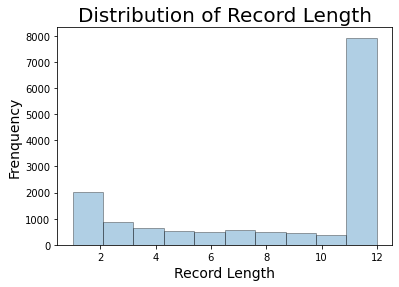

In [11]:
import matplotlib.pyplot as plt

plt.title('Distribution of Record Length',fontsize=20)
plt.xlabel(u'Record Length',fontsize=14)
plt.ylabel(u'Frenquency',fontsize=14)
plt.hist(record_list, edgecolor='k', alpha=0.35)
plt.show()

In [12]:
## Store the full-record client record in initial_data
initial_data = {}
for inde in index_dict.keys():
    if len(index_dict[inde]) == 12:
        initial_data[inde] = init_record.loc[inde]
print(len(initial_data))

7380


In [13]:
# Build the train dataset

all_features = []
all_labels = []

for key in tqdm(initial_data.keys()):
    all_labels.append(initial_data[key]['response_variable'])
    temp_sample = initial_data[key].drop(['response_variable'], axis=1)
    all_features.append(temp_sample)

print('\nThe length of All the feature is {}'.format(len(all_features)))
print('\nThe length of All labels is {}'.format(len(all_labels)))

100%|██████████| 7380/7380 [00:05<00:00, 1382.72it/s]


The length of All the feature is 7380

The length of All labels is 7380


In [14]:
feature_sample = []
label_sample = []


## k is the window size
def split_df(feature_data, label_data, k):
    
    df_list = []
    label_list = []
    i = 0
    while i+k < feature_data.shape[0]:
        temp = feature_data[i: i+k, :]
        df_list.append(temp)
        label_list.append(label_data[i+k])
        i += 1
    return df_list, label_list

for i in tqdm(range(len(all_features))):
    feature_temp_list, label_temp_list = split_df(all_features[i].values, all_labels[i].values, 4)
    for feature in feature_temp_list:
        feature_sample.append(feature)
    # feature_sample.append(feature_temp_list) 
    for label in label_temp_list:
        label_sample.append(label) ## When the sample size to 7380, should be 59040
    # label_sample.append(label_temp_list[-1]) ## Should be 5000
print(len(feature_sample))
print(len(label_sample))  ## the length should be 59040

100%|██████████| 7380/7380 [00:00<00:00, 65298.07it/s]

59040
59040


Now Construct the Model

In [15]:
from DBN import DBN
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np

In [34]:
class DBNmodel(nn.Module):
    def __init__(self, visible_unit, hidden_unit, k, learning_rate, learning_rate_decay, xvaier_init, use_gpu, 
                 num_epochs, batch_size, input_dim, class_num):
        super().__init__()
        self.dbn = DBN(visible_unit= visible_unit,
                hidden_unit=hidden_unit,
                k = k,
                learning_rate = learning_rate_decay,
                learning_rate_decay = learning_rate_decay,
                xavier_init = xvaier_init,
                use_gpu = use_gpu)
        self.linear = nn.Linear(in_features = input_dim, out_features = class_num)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, data, label):
        dbn_output = self.dbn.train_stat(data, label, num_epochs, batch_size)
        output = self.linear(self.dropout(dbn_output))
        return output


Split Training and Testing Dataset

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_sample, label_sample, test_size=0.3)

In [36]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)

train_data = TensorDataset(x_train_tensor, y_train_tensor)
train_data_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=100)

print('The Length of Train Dataloader is {}'.format(len(train_data_loader)))

The Length of Train Dataloader is 414


In [37]:
x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test)

test_data = TensorDataset(x_test_tensor, y_test_tensor)
test_data_loader = DataLoader(test_data, sampler=RandomSampler(test_data), batch_size=100)

print('The Length of Test Dataloader is {}'.format(len(test_data_loader)))

The Length of Test Dataloader is 178


In [52]:
import torch.optim as optim

visible_unit = 4 * 144
hidden_unit = [144, 100]
k = 10
learing_rate = 0.05
learning_rate_decay = True
xvaier_init = True
use_gpu = True
num_epochs = 20
batch_size = 100
input_dim = 100
class_num = 1



model = DBNmodel(visible_unit, hidden_unit, k, learing_rate, learning_rate_decay,
                 xvaier_init, use_gpu, num_epochs, batch_size, input_dim, class_num)

optimizer = optim.Adam(model.parameters())

In [53]:
#defining our loss and porting our model and loss to GPU
criterion = nn.BCEWithLogitsLoss()

model.to(device)
criterion.to(device)

BCEWithLogitsLoss()

In [23]:
def binary_accuracy(pred, actual_label):
    rounded_preds = torch.round(torch.sigmoid(pred))
    correct = (rounded_preds == actual_label).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [24]:
from sklearn.metrics import f1_score

def f_score_measure(pred, actual_label):
    rounded_preds = torch.round(torch.sigmoid(pred.cpu()))
    preds = rounded_preds.data.numpy()
    actual_labels = actual_label.cpu().data.numpy()
    score = f1_score(preds, actual_labels)

    return score

In [46]:
#defining the training method
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_F1_score = 0

    model.train()
    
    for batch in iterator:
        
        input_data = batch[0].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()
        
        predictions = model(input_data, labels).squeeze(1)
        
        loss = criterion(predictions,labels)
        
        acc = binary_accuracy(predictions, labels)
        f_score = f_score_measure(predictions, labels)

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_F1_score += f_score.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_F1_score / len(iterator)

In [41]:
#defining the validation method
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_F1_score = 0
    
    model.eval()

    
    with torch.no_grad():
    
        for batch in iterator:
            input_data = batch[0].to(device)
            labels = batch[1].to(device)

            predictions = model(input_data, labels).squeeze(1)
            
            loss = criterion(predictions, labels)
            
            acc = binary_accuracy(predictions, labels)
            f_score = f_score_measure(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_F1_score += f_score.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_F1_score / len(iterator)

In [50]:
#defining the method to calculate epoch time
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [54]:
#TRAINING!
N_EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_f_score = train(model, train_data_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_f_score = evaluate(model, test_data_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'dbn_version 1.0.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train F1_score: {train_f_score:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. F1_score: {valid_f_score:.3f}')

Epoch: 01 | Epoch Time: 1m 17s
	Train Loss: 0.301 | Train Acc: 91.10% | Train F1_score: 0.002
	 Val. Loss: 0.289 |  Val. Acc: 91.60% | Val. F1_score: 0.000


KeyboardInterrupt: ignored